# Practicum 3: Supply I - Building the model

We talked today about how electricity markets work.

We will learn today how to build a simple model of an electricity market using **pyomo**.

The data and code are based on the paper "The Efficiency and Sectoral Distributional Implications of Large-Scale Renewable Policies," by Mar Reguant.

We first load relevant libraries.

Compared to day 2, we will be adding the packages `pyomo` and the solvers `Ipopt` (non-linear solver) and `HiGHS` (mixed linear integer solver).

**Note:** I often prefer to use commercial solvers (Gurobi or CPLEX), which are available under an academic license. I use solvers that are readily available here without a license for simplicity and to ensure that everyone can access the code.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyomo.environ import *

# Note: you probably need to install these packages via pip if you haven't already:
# pip install pyomo
# pip install highspy
# conda install -c conda-forge cyipopt

In [2]:
dirpath = "/Users/marreguant/Dropbox/TEACHING/BSE/Electricity2026/day3/practicum/"

## Building the model

Now that we have clustered our data, we will build our model with the data that we have. 

The model that we will build today is a simplification from the original paper.

In the original paper, the model needed to solve for:
1. Endogenous retail prices (in a demand model, iterated to find equilibrium)
2. Endogenous investment (in same supply model, with more equations)

Here we will be simply building a simple model of market clearing.

We load the clustered data from the previous session using the CSV syntax. We combine all demand into one variable.

Before building the model, we define some model parameters related to:

* Number and costs of different technologies (loaded from a small dataset)

* Elasticity of demand and imports
  
To calibrate the demand curve, one can use different strategies. Here we compute the slope for the demand curve that is consistent with the assumed elasticity of demand. 

Notice that this is a local elasticity approximation, but it has the advantage of being a linear demand curve, which is very attractive for the purposes of linear programming.

The demand is: $ q = a - b \ p $

So the elasticity becomes: $ b \frac{p}{q} $, which we set equal to an assumed parameter.

Once we have $b$, we can back out $a$. An analogous procedure is done for imports.

In [22]:
TECHS = ["hydronuc","gas1","gas2","gas3","newgas","wind","solar"]

In [23]:
def load_and_prepare(dirpath: str):
    dfclust = pd.read_csv(f"{dirpath}/data_jaere_clustered.csv")
    tech = pd.read_csv(f"{dirpath}/data_technology.csv")

    # Re-scaling
    dfclust["weights"] = dfclust["weights"] / dfclust["weights"].sum()

    # One demand type (sum of components)
    dfclust["demand"] = (
        dfclust["q_residential"] + dfclust["q_commercial"] + dfclust["q_industrial"]
    )

    # Calibrate demand curve: demand = a - b * price
    elas = np.array([0.1, 0.2, 0.5, 0.3])
    dfclust["b"] = elas[0] * dfclust["demand"] / dfclust["price"]
    dfclust["b"] = dfclust["b"].mean()  # constant slope across t
    dfclust["a"] = dfclust["demand"] + dfclust["b"] * dfclust["price"]

    # Calibrate imports: imports = am + bm * price
    dfclust["bm"] = elas[3] * dfclust["imports"] / dfclust["price"]
    dfclust["am"] = dfclust["imports"] - dfclust["bm"] * dfclust["price"]

    # Set index names for tech
    tech.index = TECHS
    tech.at["newgas", "capUB"] = 0.0

    return dfclust, tech

dfclust, tech = load_and_prepare(dirpath)

In [24]:
dfclust.describe()

,price,imports,q_commercial,q_industrial,q_residential,wind_cap,solar_cap,hydronuc,weights,demand,b,a,bm,am
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000
mean,38.505476,7.524257,12.953196,4.122400,11.075335,0.340955,0.260549,5.034605,0.010000,28.150932,9.232864e-02,31.706090,0.077144,5.266980
std,16.032924,1.354806,2.816034,1.154978,3.270312,0.161457,0.273990,1.934417,0.005392,5.057071,1.394770e-17,6.100057,0.110954,0.948364
min,1.663115,4.247898,9.262359,2.600491,4.399502,0.093590,0.001559,2.363158,0.000898,20.605153,9.232864e-02,21.322098,0.012867,2.973528
25%,28.996742,6.536902,10.746648,3.223270,8.850752,0.198401,0.017448,3.439219,0.005846,24.280314,9.232864e-02,27.223763,0.049859,4.575831
50%,37.279651,7.570554,12.388104,3.833469,10.007544,0.334676,0.067964,4.568591,0.008996,27.093761,9.232864e-02,31.136484,0.061616,5.299387
75%,45.780669,8.700303,14.679611,4.744508,13.288205,0.468172,0.545671,6.094806,0.012843,30.784737,9.232864e-02,34.317781,0.076286,6.090212
max,137.115844,9.798136,22.176628,7.620034,20.492173,0.681777,0.793407,9.680505,0.026009,41.809606,9.232864e-02,50.379412,1.135820,6.858695


In [25]:
tech

,techname,heatrate,heatrate2,F,capLB,capUB,new,renewable,solar,thermal,e,e2,c,c2
hydronuc,Hydro/Nuclear,10.000000,0.000000,0,1.000,1.000,0,0,0,0,0.000000,0.000000,10.000000,0.000000
gas1,Existing 1,6.671990,0.092912,0,7.500,11.500,0,0,0,1,0.360184,0.004886,23.351965,0.325193
gas2,Existing 2,9.794118,0.286247,0,10.500,14.500,0,0,0,1,0.546134,0.011078,34.279413,1.001866
gas3,Existing 3,13.818120,20.535160,0,0.578,0.578,0,0,0,1,0.816768,0.234476,48.363420,71.873060
newgas,New Gas,6.600000,0.000000,978,0.000,0.000,1,0,0,1,0.350000,0.000000,23.351965,0.325193
wind,Wind,0.000000,0.000000,1250,0.000,100.000,1,1,0,0,0.000000,0.000000,0.000000,0.000000
solar,Solar,0.000000,0.000000,1250,0.000,100.000,1,1,1,0,0.000000,0.000000,0.000000,0.000000


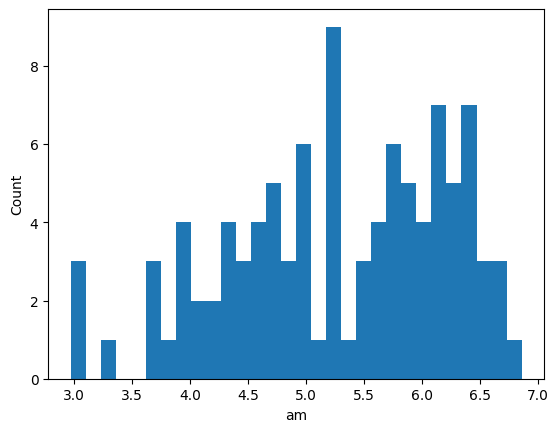

In [26]:
# intercept if import curve (imports at zero price)
plt.hist(dfclust["am"], bins=30)
plt.xlabel("am")
plt.ylabel("Count")
plt.show()

### Non-linear solver

We are now ready to clear the market. We will **maximize welfare** using a non-linear solver.

$$ \max \ CS - Costs \\

\text{s.t.} \ \text{operational constraints, market clearing}. $$

We will then consider an approach **based on FOC**, which is useful to extend to strategic firms as in Bushnell, Mansur, and Saravia (2008) and Ito and Reguant (2016).

In perfect competition, the two approaches should be equivalent--and they are in my computer!

In [27]:
def clear_market_min(data, tech, wind_gw=5.0, solar_gw=2.0, solver_name="ipopt"):
    T = len(data)

    # Plain python lookups (NOT Params)
    c     = {k: float(tech.at[k, "c"])     for k in TECHS}
    capUB = {k: float(tech.at[k, "capUB"]) for k in ["gas1","gas2","gas3","newgas"]}

    m = ConcreteModel()
    m.T = RangeSet(0, T-1)
    m.I = Set(initialize=TECHS, ordered=False)

    m.price   = Var(m.T, domain=Reals)
    m.demand  = Var(m.T, domain=Reals)
    m.imports = Var(m.T, domain=Reals)
    m.q       = Var(m.T, m.I, domain=NonNegativeReals)
    m.gs      = Var(m.T, domain=Reals)
    m.costs   = Var(m.T, domain=Reals)

    # Objective: gross surplus - variable costs
    m.obj = Objective(
        expr=sum(data.weights[t] * (m.gs[t] - m.costs[t]) for t in m.T),
        sense=maximize
    )

    # Demand/import schedules + market clearing
    m.demand_curve  = Constraint(m.T, expr={t: m.demand[t]  == data.a[t]  - data.b[t]  * m.price[t] for t in m.T})
    m.imports_curve = Constraint(m.T, expr={t: m.imports[t] == data.am[t] + data.bm[t] * m.price[t] for t in m.T})
    m.market_clear  = Constraint(m.T, expr={t: m.demand[t]  == sum(m.q[t,k] for k in m.I) + m.imports[t] for t in m.T})

    # Surplus + costs
    m.surplus_def = Constraint(
        m.T,
        expr={t: m.gs[t] == (data.a[t] - m.demand[t]) * m.demand[t] / data.b[t] + (m.demand[t]**2) / (2.0 * data.b[t])
              for t in m.T}
    )
    m.cost_def = Constraint(
        m.T,
        expr={t: m.costs[t] == sum(c[k] * m.q[t,k] for k in m.I)
                           + (m.imports[t] - data.am[t])**2 / (2.0 * data.bm[t])
              for t in m.T}
    )

    # Capacity constraints (minimal lines)
    m.cap_hydronuc = Constraint(m.T, expr={t: m.q[t,"hydronuc"] <= data.hydronuc[t] for t in m.T})
    m.cap_gas      = Constraint(m.T, Set(initialize=list(capUB)), expr={(t,k): m.q[t,k] <= capUB[k] for t in m.T for k in capUB})
    m.cap_wind     = Constraint(m.T, expr={t: m.q[t,"wind"]  <= wind_gw  * data.wind_cap[t]  for t in m.T})
    m.cap_solar    = Constraint(m.T, expr={t: m.q[t,"solar"] <= solar_gw * data.solar_cap[t] for t in m.T})

    res = SolverFactory(solver_name).solve(m, tee=False)
    term = str(res.solver.termination_condition)

    if term == "optimal":
        price   = np.array([value(m.price[t]) for t in m.T])
        demand  = np.array([value(m.demand[t]) for t in m.T])
        imports = np.array([value(m.imports[t]) for t in m.T])
        q       = {k: np.array([value(m.q[t,k]) for t in m.T]) for k in TECHS}

        w_arr = data["weights"].to_numpy()
        avg_price = float(np.sum(price * w_arr) / np.sum(w_arr))

        gen_cost_t = sum(c[k] * q[k] for k in TECHS)
        imp_cost_t = (imports - data["am"].to_numpy())**2 / (2.0 * data["bm"].to_numpy())
        total_cost = float(np.sum(w_arr * (gen_cost_t + imp_cost_t)))

        return {"status": term, "avg_price": avg_price, "price": price, "demand": demand,
                "imports": imports, "q": q, "cost": total_cost}

    return {"status": term}


In [28]:
results_min = clear_market_min(dfclust, tech)
print("MIN status:", results_min["status"], "avg_price:", results_min.get("avg_price"), "cost:", results_min.get("cost"))


MIN status: optimal avg_price: 30.887575943798957 cost: 414.36583464470755


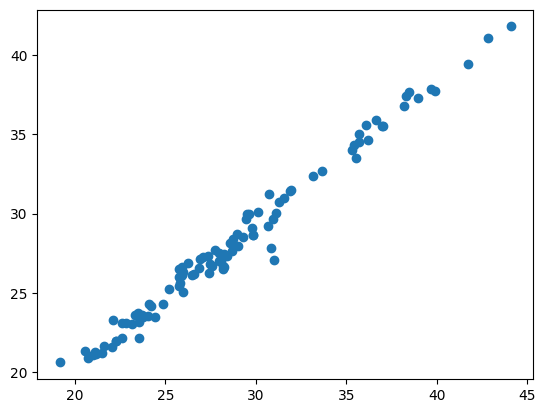

In [29]:
plt.scatter(results_min["demand"],dfclust.demand)
plt.show()

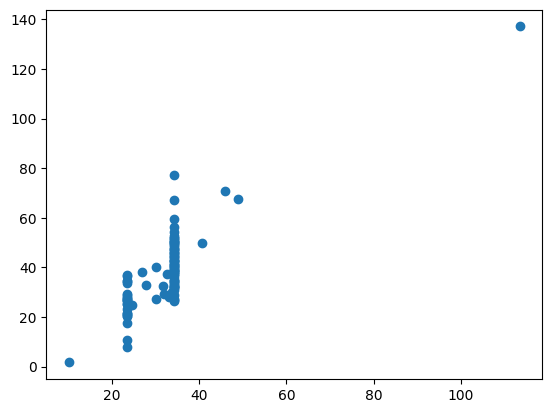

In [31]:
# Prices correlated, but not as nice of course, much harder!
plt.scatter(results_min["price"],dfclust.price)
plt.show()

In [32]:
results_more_wind = clear_market_min(dfclust, tech, wind_gw=15.0)
print("MORE WIND status:", results_more_wind["status"], "avg_price:", results_more_wind.get("avg_price"), "cost:", results_more_wind.get("cost"))


MORE WIND status: optimal avg_price: 28.00674703669592 cost: 330.85980747067197


### Mixed integer solver

The key to the FOC representation is to model the marginal cost of power plants. The algorithm will be using power plants until $MC = Price$. 

**Note**: In the market power version of this algorithm, it sets $MR = MC$.

We will be using **integer variables** to take into consideration that FOC are not necessarily at an interior solution in the presence of capacity constraints.

If $Price < MC(0)$, a technology will not produce.

If $Price > MC(K)$, a technology is at capacity and can no longer increase output. In such case, the firm is earning a markup even under perfect competition. We define the shadow value as:

$\psi = Price - MC$

Shadow values define the rents that firms make. These are directly used in an expaded version of the model with investment.

We will define these conditions using binary variables (0 or 1):

* $u_1$ will turn on when we use a technology.
* $u_2$ will turn on when we use a technology at capacity. 
* $\psi$ can only be positive if $u_2=1$.

Compared to the previous approach:
* There will not be an objective function.

* We will use a solver for mixed integer programming (`HiGHS`).

In [35]:
def clear_market_foc(data, tech, wind_gw=5.0, solar_gw=2.0, theta=0.0, M=1e3, solver_name="highs"):
    """
    FOC-based equilibrium (MILP).
    """
    T = len(data)

    # plain python lookups (no Params)
    c     = {k: float(tech.at[k, "c"])     for k in TECHS}
    capUB = {k: float(tech.at[k, "capUB"]) for k in ["gas1","gas2","gas3","newgas"]}

    m = ConcreteModel()
    m.T = RangeSet(0, T-1)
    m.I = Set(initialize=TECHS, ordered=False)

    m.price   = Var(m.T, domain=Reals)
    m.demand  = Var(m.T, domain=Reals)
    m.imports = Var(m.T, domain=Reals)

    m.q      = Var(m.T, m.I, domain=NonNegativeReals)
    m.shadow = Var(m.T, m.I, domain=NonNegativeReals)
    m.u1     = Var(m.T, m.I, domain=Binary)  # used
    m.u2     = Var(m.T, m.I, domain=Binary)  # at cap

    # Objective: minimize weighted average price
    m.obj = Objective(expr=sum(data.weights[t] * m.price[t] for t in m.T), sense=minimize)

    # Demand/import schedules + market clearing
    m.demand_curve  = Constraint(m.T, expr={t: m.demand[t]  == data.a[t]  - data.b[t]  * m.price[t] for t in m.T})
    m.imports_curve = Constraint(m.T, expr={t: m.imports[t] == data.am[t] + data.bm[t] * m.price[t] for t in m.T})
    m.market_clear  = Constraint(m.T, expr={t: m.demand[t]  == sum(m.q[t,k] for k in m.I) + m.imports[t] for t in m.T})

    # Capacity values precomputed (fast; avoids pandas + function calls inside expressions)
    cap = {(t,k):
           (data.hydronuc[t] if k=="hydronuc" else
            wind_gw  * data.wind_cap[t] if k=="wind" else
            solar_gw * data.solar_cap[t] if k=="solar" else
            capUB[k])
           for t in m.T for k in m.I}

    m.cap_ub = Constraint(m.T, m.I, expr={(t,k): m.q[t,k] <= m.u1[t,k] * cap[(t,k)] for t in m.T for k in m.I})
    m.cap_lb = Constraint(m.T, m.I, expr={(t,k): m.q[t,k] >= m.u2[t,k] * cap[(t,k)] for t in m.T for k in m.I})
    m.u_link = Constraint(m.T, m.I, expr={(t,k): m.u1[t,k] >= m.u2[t,k] for t in m.T for k in m.I})

    # Linear FOC envelope (MILP-compatible): price - c - markup - shadow
    denom = {t: float(data.b[t] + data.bm[t]) for t in m.T}
    m.foc_lb = Constraint(
        m.T, m.I,
        expr={(t,k): (m.price[t] - c[k] - float(theta) * m.q[t,k] / denom[t] - m.shadow[t,k]) >= -M * (1 - m.u1[t,k])
              for t in m.T for k in m.I}
    )
    m.foc_ub = Constraint(
        m.T, m.I,
        expr={(t,k): (m.price[t] - c[k] - float(theta) * m.q[t,k] / denom[t] - m.shadow[t,k]) <= 0.0
              for t in m.T for k in m.I}
    )
    m.shadow_cap = Constraint(m.T, m.I, expr={(t,k): m.shadow[t,k] <= M * m.u2[t,k] for t in m.T for k in m.I})

    res = SolverFactory(solver_name).solve(m, tee=False)
    term = str(res.solver.termination_condition)

    if term == "optimal":
        price   = np.array([value(m.price[t])   for t in m.T])
        demand  = np.array([value(m.demand[t])  for t in m.T])
        imports = np.array([value(m.imports[t]) for t in m.T])
        q       = {k: np.array([value(m.q[t,k])      for t in m.T]) for k in TECHS}
        shadow  = {k: np.array([value(m.shadow[t,k]) for t in m.T]) for k in TECHS}
        u1      = {k: np.array([value(m.u1[t,k])     for t in m.T]) for k in TECHS}
        u2      = {k: np.array([value(m.u2[t,k])     for t in m.T]) for k in TECHS}

        w_arr = data["weights"].to_numpy()
        avg_price = float(np.sum(price * w_arr) / np.sum(w_arr))

        # Ex-post cost accounting 
        gen_cost_t = sum(c[k] * q[k] for k in TECHS)
        imp_cost_t = (imports - data["am"].to_numpy()) ** 2 / (2.0 * data["bm"].to_numpy())
        total_cost = float(np.sum(w_arr * (gen_cost_t + imp_cost_t)))

        return {"status": term, "avg_price": avg_price, "price": price, "demand": demand, "imports": imports,
                "q": q, "shadow": shadow, "u1": u1, "u2": u2, "cost": total_cost}

    return {"status": term}

In [36]:
# FOC / MILP
results_foc = clear_market_foc(dfclust, tech)
print("FOC status:", results_foc["status"], "avg_price:", results_foc.get("avg_price"), "cost:", results_foc.get("cost"))


FOC status: optimal avg_price: 30.887576054662837 cost: 414.3658359247432


We can check that u1, u2 and the shadow values are correct. For example, at hour 1, tech gas1 is at max capacity, while gas2 is setting the price and therefore it does not have inframarginal rents (shadow = 0)

In [37]:
if results_foc.get("status", "").lower() == "optimal":
    print("Gas 1 " + str(results_foc["u1"]["gas1"][0]) + ' ' + str(results_foc["u2"]["gas1"][0]) + ' '+ str(results_foc["shadow"]["gas1"][0]))
    print("Gas 2 " + str(results_foc["u1"]["gas2"][0]) + ' ' + str(results_foc["u2"]["gas2"][0]) + ' '+ str(results_foc["shadow"]["gas2"][0]))

Gas 1 1.0 1.0 10.927447999999977
Gas 2 1.0 0.0 0.0


In [38]:
results_foc_mp = clear_market_foc(dfclust, tech, theta=1.0)
print("FOC status:", results_foc_mp["status"], "avg_price:", results_foc_mp.get("avg_price"), "cost:", results_foc_mp.get("cost"))

FOC status: optimal avg_price: 57.81948955609634 cost: 416.18044726892464


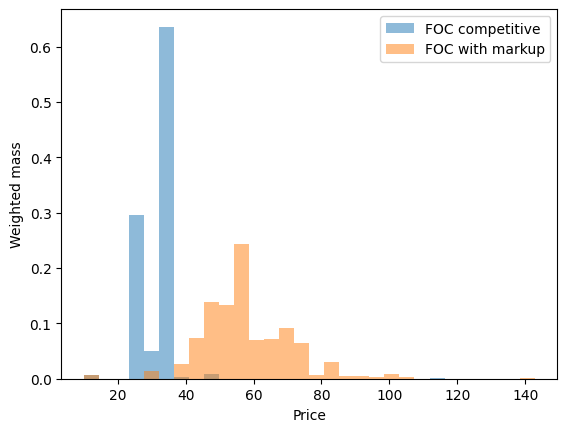

In [39]:
p1 = results_foc["price"]
p2 = results_foc_mp["price"]
w  = dfclust["weights"].to_numpy()

# common bins across both distributions
bins = np.histogram_bin_edges(np.r_[p1, p2], bins=30)

plt.hist(p1, bins=bins, weights=w, alpha=0.5, label="FOC competitive")
plt.hist(p2, bins=bins, weights=w, alpha=0.5, label="FOC with markup")
plt.xlabel("Price")
plt.ylabel("Weighted mass")
plt.legend()
plt.show()

### Discussion of pros and cons:

* Mixed integer programming has advantages due to its robust finding of global solutions.

* Here, we are using first-order conditions, so a question arises regarding the validity of such conditions to fully characterize a unique solution in more general settings.

* Non-linear solvers explore the objective function but do not tend to be global in nature.

* Non-linear solvers cannot deal with an oligopolistic setting in a single model, as several agents are maximizing profits. We would need to iterate.

## Follow-up exercises

1. Imagine each technology is a firm, which now might exercise market power. Can you modify clear\_market\_foc to account for market power as in BMS (2008)? [in class]

2. (*) The function is prepared to take several amounts of solar and wind. What are the impacts on prices as you increase solar and wind? Save prices for different values of wind or solar investment and plot them. Does your answer depend a lot on the number of clusters?

3. (*) [Harder] Making some assumptions on the fixed costs of solar and wind, can you expand the model to solve for investment? For the FOC approach, this will require a FOC for the zero profit entry condition.